In [1]:
%run setup.py

In [6]:
snrs = np.geomspace(1,1000,51)
eccens = [0.,0.8,0.95,0.99]

# Fixed parameters
period_t = 10
asini_t = 100
varpi_t = 0.
tref_t = 0.
freqs = np.array([50])
amps = np.array([0.1])
eccen_t = 0.9

time = np.arange(0, 3*period_t, 1.0 / (24 * 30))

In [10]:
import theano
from exoplanet.orbits import get_true_anomaly
from maelstrom.synthetic import SyntheticBinary
import theano.tensor as tt

lc = SyntheticBinary(time, freqs, amps, period_t, eccen_t, asini_t, varpi_t, tref_t)
lc.add_noise(snr=50)

time_tensor = theano.shared(lc.time)
flux_tensor = theano.shared(lc.flux)

with pm.Model() as fit_model:
    period = pm.Flat("period", testval=9)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)
    eccen = pm.Flat('eccen', testval=eccen_t)#pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=eccen_t)
    omega, phi = 0., 0.
    
    M = 2.0 * np.pi * time_tensor / period - phi
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))

    # Positive
    arg = 2. * np.pi * freqs * (time_tensor[:, None] - ((asini) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    DT = D.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux_tensor))
    lc_model = tt.dot(D, w)

    pm.Normal('obs', mu=lc_model, 
              sd=tt.exp(logs_lc), 
              observed=flux_tensor)
    
    fit_params = [v for v in fit_model.vars if v.name not in ["period", "eccen"]]
    
def run_fit(time, flux, period, asini, eccen):
    with fit_model:
        time_tensor.set_value(time)
        flux_tensor.set_value(flux)
        
        start = dict(fit_model.test_point)
        start['period'] = period
        start['asini'] = asini
        start['eccen'] = eccen
        
        return xo.optimize(start, vars=fit_params, verbose=False)

Make sure it all works..

In [13]:
lc = SyntheticBinary(time, freqs, amps, period_t, eccen_t, asini_t, varpi_t, tref_t)
lc.add_noise(snr=50000)

opt = run_fit(lc.time, lc.flux, period_t, asini_t, eccen_t)
opt

In [20]:
from tqdm import tqdm
snr=5
eccen_t = 0.5
lc = SyntheticBinary(time, freqs, amps,
     period_t, eccen_t, asini_t, varpi_t, tref_t)
s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
asini_x = []
for i in tqdm(range(100)):
    noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
    # Run the fit
    opt = run_fit(lc.time, noisy_flux, period_t, asini_t, eccen_t)
    asini_x.append(opt['asini'])

100%|██████████| 100/100 [02:39<00:00,  2.14s/it]


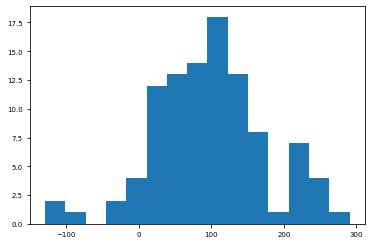

In [21]:
plt.hist(asini_x, bins=15);

## FITTING

In [21]:
snrs = np.geomspace(1,1000,51)
eccens = [0.,0.5,0.99]

In [22]:
from tqdm import tqdm

asinis_all_maelstrom = []
uncertainties_all_maelstrom = []

for eccen in eccens:
    eccen_t = eccen
    lc = SyntheticBinary(time, freqs, amps,
         period_t, eccen_t, asini_t, varpi_t, tref_t)
    
    uncertainties = []
    asinis = []
    # Iterate over each SNR for the given eccentricity
    for snr in tqdm(snrs):
        s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
        asini_x = []
#         for i in range(100):
        noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
        # Run the fit
        opt = run_fit(lc.time, noisy_flux, period_t, asini_t, eccen_t)
#         asini_x.append(opt['asini'])
        asinis.append(opt['asini'])
        
#         # Get Hessian estimate
#         with fit_model:
#             hess = pm.find_hessian(opt, vars=[asini])
#         uncertainties.append(1/np.sqrt(np.abs(np.diag(hess)))[0])
    asinis_all_maelstrom.append(asinis)
#     uncertainties_all_maelstrom.append(uncertainties)

asinis_all_maelstrom = np.array(asinis_all_maelstrom)
#uncertainties_all_maelstrom = np.array(uncertainties_all)

100%|██████████| 51/51 [1:47:17<00:00, 110.70s/it]


In [24]:
np.savetxt('asinis_all_maelstrom_MC.txt', asinis_all_maelstrom)

In [33]:
# # Fixed parameters
# period_t = 10
# asini_t = 100
# varpi_t = 0.
# tref_t = 0.
# freqs = np.array([50])
# amps = np.array([0.1])
# eccen_t = 0.9
# time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps, period_t, eccen_t, asini_t, varpi_t, tref_t)
lc.add_noise(snr=50)

ms = Maelstrom(lc.time, lc.flux, freq=freqs)
a, b = ms.get_time_delay(segment_size=2.)
a += ms.time_mid

td_time_tensor = theano.shared(a)
td_td_tensor = theano.shared(b[:,0])

with pm.Model() as subdivide_model:
    period = pm.Flat("period", testval=period_t)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)
    eccen = pm.Flat('eccen', testval=eccen_t)#pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=eccen_t)
    omega, phi = 0., 0.
    
    M = 2.0 * np.pi * td_time_tensor / period - phi
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))

    tau = (asini) * psi

    pm.Normal('obs', mu=tau, 
              sd=tt.exp(logs_lc), 
              observed=td_td_tensor)
    
    fit_params_subdivide = [v for v in subdivide_model.vars if v.name not in ["period", "eccen"]]

In [14]:
def run_fit_subdivide(td_time, td_td, period, asini, eccen):
    with subdivide_model:
        td_time_tensor.set_value(td_time)
        td_td_tensor.set_value(td_td)
        
        start = dict(subdivide_model.test_point)
        start['period'] = period
        start['asini'] = asini
        start['eccen'] = eccen
        
        return xo.optimize(start, vars=fit_params_subdivide, verbose=False)

In [15]:
from tqdm import tqdm

asinis_all_subdivide = []
uncertainties_all_subdivide = []

for eccen in eccens:
    eccen_t = eccen
    lc = SyntheticBinary(time, freqs, amps,
         period_t, eccen_t, asini_t, varpi_t, tref_t)
    
    uncertainties = []
    asinis = []
    # Iterate over each SNR for the given eccentricity
    for snr in tqdm(snrs):
        s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
        np.random.seed(42)
        noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
        # Run the fit
        ms = Maelstrom(lc.time, noisy_flux, freq=freqs)
        a, b = ms.get_time_delay(segment_size=2.)
        a += ms.time_mid

        opt = run_fit_subdivide(a, b[:,0], period_t, asini_t, eccen_t)
        asinis.append(opt['asini'])
        
        # Get Hessian estimate
#         with subdivide_model:
#             hess = pm.find_hessian(opt, vars=[asini])
#         uncertainties.append(1/np.sqrt(np.abs(np.diag(hess)))[0])
    asinis_all_subdivide.append(asinis)
#     uncertainties_all_subdivide.append(uncertainties)

asinis_all_subdivide = np.array(asinis_all_subdivide)
# uncertainties_all_subdivide = np.array(uncertainties_all_subdivide)

100%|██████████| 51/51 [00:28<00:00,  2.26it/s]


In [18]:
np.savetxt('paper/data/asinis_all_subdivide_10d', asinis_all_subdivide)

In [7]:
asinis_all_subdivide10d = np.loadtxt('../data/asinis_all_subdivide_10d')
asinis_all_subdivide100d = np.loadtxt('../data/asinis_all_subdivide_100d')
asinis_all_maelstrom10d = np.loadtxt('../data/asinis_all_maelstrom_10d')
asinis_all_maelstrom100d = np.loadtxt('../data/asinis_all_maelstrom_100d')

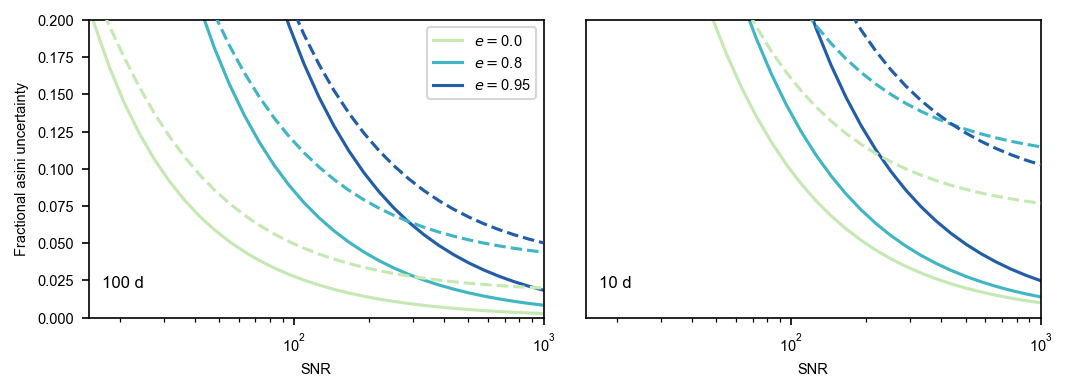

In [9]:
#plt.figure(figsize=mnras_size(240.))
from maelstrom.utils import unique_colors
colors = unique_colors(3, cmap='YlGnBu')

fig, axes = plt.subplots(1,2, figsize=[7,2.5], constrained_layout=True)

ax = axes[0]
for asini_subd, asini_mael, color, eccen in zip(asinis_all_subdivide100d, asinis_all_maelstrom100d, colors, eccens):
    ax.plot(snrs, (100 - asini_subd) / 100, c=color, linestyle='dashed', zorder=5)
    ax.plot(snrs, (100 - asini_mael) / 100, c=color, label=r'$e=$' + str(eccen), zorder=1)
    
ax = axes[1]
for asini_subd, asini_mael, color, eccen in zip(asinis_all_subdivide10d, asinis_all_maelstrom10d, colors, eccens):
    ax.plot(snrs, (100 - asini_subd) / 100, c=color, linestyle='dashed', zorder=5)
    ax.plot(snrs, (100 - asini_mael) / 100, c=color, label=r'$e=$' + str(eccen), zorder=1)
    
axes[0].set_xlim(15,1000)
axes[0].set_ylim(0,0.2)
axes[1].set_xlim(15,1000)
axes[1].set_ylim(0,0.2)

axes[1].set_yticks([])
axes[0].legend(loc=0)

axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].set_xlabel('SNR')
axes[1].set_xlabel('SNR')

axes[0].set_ylabel('Fractional asini uncertainty')

axes[0].text(17,0.02, '100 d', fontsize=8)
axes[1].text(17,0.02, '10 d', fontsize=8)

plt.savefig(overleaf_path + 'comparison.pdf', dpi=300, bbox_inches='tight', pad_inches=0.)